## CNN para classificação Multiclass de Imagens (MNIST)

### Visualização dos filtros e dos featuremaps

O MNIST é uma espécie de Hello World da classificação de imagens com imagens de dígitos escritos à mão.
A API do torchvision já dispõe de uma função para fazer o download deste dataset. Vamos no entanto optar por ir buscar os CSVs do dataset a https://www.kaggle.com/oddrationale/mnist-in-csv 

Iremos utilizar uma rede neuronal convolucional para classificação do dígito em cada imagem de 28x28.


**Autor:**

Eduardo Cunha PG55939

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

from livelossplot import PlotLosses

np.random.seed(0) 
torch.manual_seed(0)
import random
random.seed(0)

In [7]:
PATH = './'
PATH_TRAIN = 'AP_Aula3_PL_datasets/mnist_train.csv'
PATH_TEST = 'AP_Aula3_PL_datasets/mnist_test.csv'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados.

In [9]:
# criar as funções de transformação
train_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,)) # parâmetros por canal da imagem, image = (image - mean) / std
        ])
test_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,)) # parâmetros por canal da imagem, image = (image - mean) / std
        ])

In [10]:
# buscar o dataset utilizando os CSVs e uma classe para o dataset

# definição classe para o dataset
class CSVDataset(Dataset):
  # ler o dataset
  def __init__(self, path, transform=None):
    self.transform = transform
    # ler o ficheiro csv para um dataframe
    df_set = pd.read_csv(path, header=0)
    # separar os inputs e os outputs
    self.x = df_set.values[:, 1:]
    self.y = df_set.values[:, 0]

    # garantir que os inputs e labels sejam floats
    self.x = self.x.astype('float32')
    self.y = self.y.astype('long')
    #print(self.x.shape)
    #print(self.y.shape)
        
  # número de casos no dataset
  def __len__(self):
    return len(self.x)

  # retornar um caso
  def __getitem__(self, idx):
    label = self.y[idx]
    image = self.x[idx]       
    if self.transform is not None:
      image = self.transform(image)
    return image, label
    
  # retornar índices para casos de treino e de teste em formato imagem
  def get_TensorDataset(self):
    x = self.x.reshape(len(self.x), 1, 28, 28)
    xmax, xmin = x.max(), x.min()
    x = (x - xmin)/(xmax - xmin)
    x  = torch.from_numpy(np.array(x)).float()
    y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
    cases = torch.utils.data.TensorDataset(x,y)
    return cases 

#com holdout
def prepare_data_loaders(path_train, path_test):
  dataset_train = CSVDataset(path_train,transform=train_transform)
  dataset_test = CSVDataset(path_test,transform=test_transform)
  train = dataset_train.get_TensorDataset()
  train_size = int(0.8 * len(train))
  val_size = len(train) - train_size
  train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
  test = dataset_test.get_TensorDataset()
    
  train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
  val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
  test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
  train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
  val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
  test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
  return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

# preparar os dados
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [11]:
# função para colocar o label por extenso

def output_label(label,mapping='label'):
    if mapping == 'ext':
        output_mapping = { 0:"zero", 1:"um", 2:"dois", 3:"tres", 4:"quatro", 5:"cinco", 6:"seis", 7:"sete", 8:"oito", 9:"nove" }
    elif mapping == 'ext2':
        output_mapping = { "0":"zero", "1":"um", "2":"dois", "3":"tres", "4":"quatro", "5":"cinco", "6":"seis", "7":"sete", "8":"oito", "9":"nove" }
    else:
        output_mapping = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label) # pode ser um tensor
    return output_mapping[input]

torch.Size([32, 1, 28, 28])


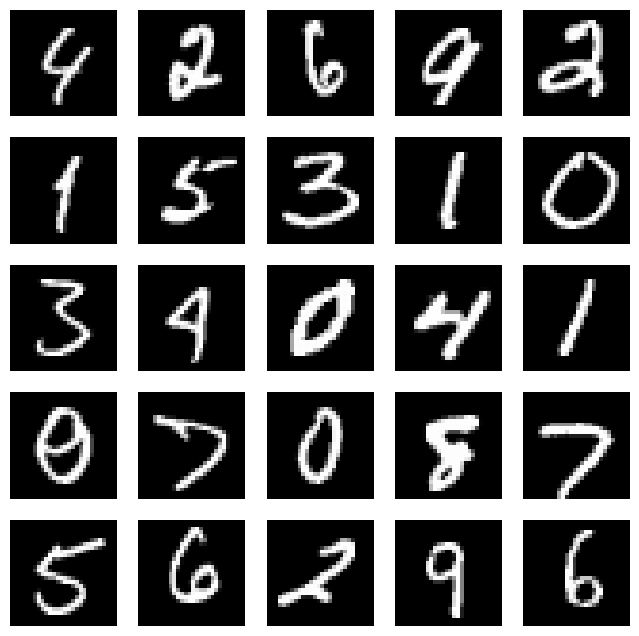

In [12]:
# Visualização das imagens

def visualize_mnist_images(dl):
    # get one batch of images
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    #inputs = inputs.reshape(len(inputs), 1, 28, 28)
    #print(inputs.shape)
    # plot some images
    plt.figure(figsize=(8,8))
    for i in range(25):
        # define subplot

        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid(visible=None)
        # plot raw pixel data
        plt.imshow(inputs[i][0], cmap='gray')
    # show the figure
    plt.show()


visualize_mnist_images(train_dl)

## 2. Definir o Modelo.

CNN Model 1

In [13]:
# CNN Model1: Sequential (Conv, ReLU, MaxPool), Sequential, Linear, ReLU, Linear, Softmax
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=5*5*32, out_features=100) # fully connected layer
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10) # output layer
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 4*4*50) # flatten
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 32, 26, 26]          320
│    └─ReLU: 2-2                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 32, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          9,248
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 100]                 80,100
├─ReLU: 1-4                              [32, 100]                 --
├─Linear: 1-5                            [32, 10]                  1,010
├─Softmax: 1-6                           [32, 10]                  --
Tota

In [14]:
# CNN Model2: Sequential (Conv, ReLU, MaxPool), Sequential, Linear
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(in_features=32 * 5 * 5, out_features=10)  # Fully connected 1
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) #Flatten
        out = self.fc1(out) #Dense
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [32, 10]                  --
├─Sequential: 1-1                        [32, 16, 13, 13]          --
│    └─Conv2d: 2-1                       [32, 16, 26, 26]          160
│    └─ReLU: 2-2                         [32, 16, 26, 26]          --
│    └─MaxPool2d: 2-3                    [32, 16, 13, 13]          --
├─Sequential: 1-2                        [32, 32, 5, 5]            --
│    └─Conv2d: 2-4                       [32, 32, 11, 11]          4,640
│    └─ReLU: 2-5                         [32, 32, 11, 11]          --
│    └─MaxPool2d: 2-6                    [32, 32, 5, 5]            --
├─Linear: 1-3                            [32, 10]                  8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 21.68
Input size (MB): 0.10
Forward/backward pass size (MB): 3.76
Params size (MB): 0.05
Estimated Total Size (MB): 3.91


In [15]:
# CNN Model3: Sequential (Conv, BatchNorm, ReLU, MaxPool), Sequential, Linear, Dropout, Linear, Linear
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 32, 28, 28]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 28, 28]          64
│    └─ReLU: 2-3                         [32, 32, 28, 28]          --
│    └─MaxPool2d: 2-4                    [32, 32, 14, 14]          --
├─Sequential: 1-2                        [32, 64, 6, 6]            --
│    └─Conv2d: 2-5                       [32, 64, 12, 12]          18,496
│    └─BatchNorm2d: 2-6                  [32, 64, 12, 12]          128
│    └─ReLU: 2-7                         [32, 64, 12, 12]          --
│    └─MaxPool2d: 2-8                    [32, 64, 6, 6]            --
├─Linear: 1-3                            [32, 600]                 1,383,000
├─Dropout: 1-4                           [32, 600]                 --
├─

In [16]:
# CNN Model4: Sequential (Conv, BatchNorm, ReLU, MaxPool, Dropout), Linear, Linear
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*12*12, out_features=128) # 16928
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [32, 10]                  --
├─Sequential: 1-1                        [32, 32, 12, 12]          --
│    └─Conv2d: 2-1                       [32, 32, 24, 24]          832
│    └─BatchNorm2d: 2-2                  [32, 32, 24, 24]          64
│    └─ReLU: 2-3                         [32, 32, 24, 24]          --
│    └─MaxPool2d: 2-4                    [32, 32, 12, 12]          --
│    └─Dropout2d: 2-5                    [32, 32, 12, 12]          --
├─Linear: 1-2                            [32, 128]                 589,952
├─Linear: 1-3                            [32, 10]                  1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 34.26
Input size (MB): 0.10
Forward/backward pass size (MB): 9.47
Params size (MB): 2.37
Estimated Total Size (MB): 11.94


## 3. Treinar o Modelo.

In [17]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {} # para o livelossplot
        # Train phase
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for batch_i, (inputs, labels) in enumerate(train_dl): 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            #acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        # Validation phase
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1) # Get predictions from the maximum value
            #acc = accuracy_score(labels.numpy(), np.argmax(outputs.detach().numpy(), axis=1))
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        #print(f'Epoch {epoch:03}: | Loss: {epoch_loss/len(train_dl):.5f} | Acc: {epoch_acc/len(train_dl):.3f}')      
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file) # para gravar o modelo no final do treino

In [18]:
######### CNNModel_1 ################
model = CNNModel_1()
model.to(device)

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

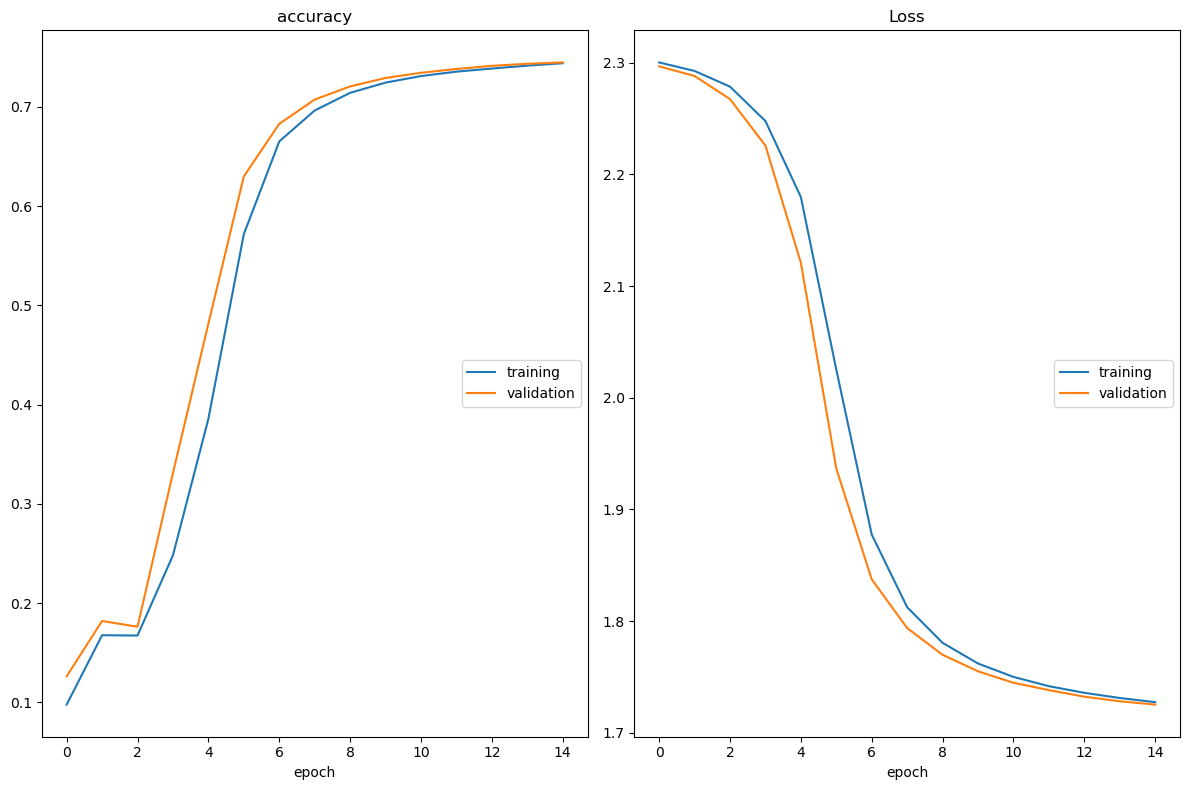

accuracy
	training         	 (min:    0.098, max:    0.744, cur:    0.744)
	validation       	 (min:    0.126, max:    0.745, cur:    0.745)
Loss
	training         	 (min:    1.727, max:    2.300, cur:    1.727)
	validation       	 (min:    1.725, max:    2.297, cur:    1.725)
Tempo gasto: 44.25924728299992 segundos


In [19]:
# treino do modelo CNNModel_1
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('./CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [20]:
######### CNNModel_2 ################
model = CNNModel_2()
model.to(device)

CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

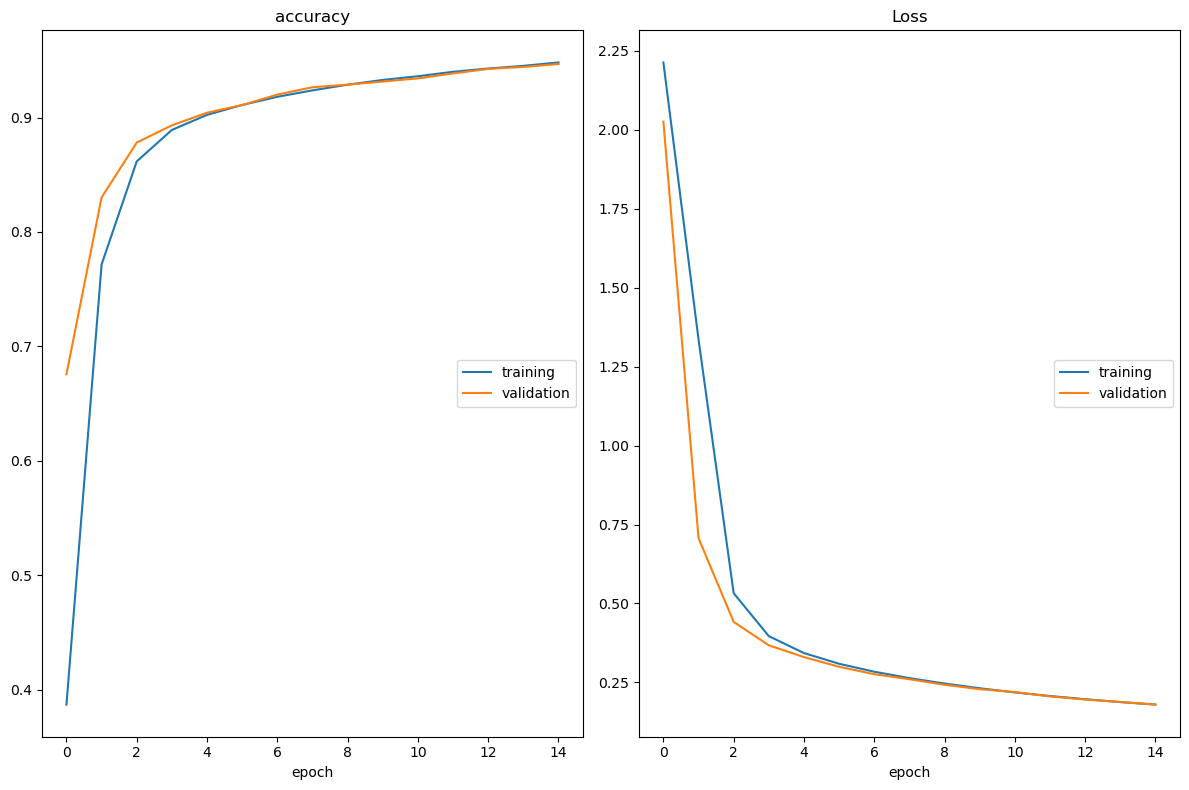

accuracy
	training         	 (min:    0.387, max:    0.948, cur:    0.948)
	validation       	 (min:    0.676, max:    0.947, cur:    0.947)
Loss
	training         	 (min:    0.180, max:    2.214, cur:    0.180)
	validation       	 (min:    0.180, max:    2.026, cur:    0.180)
Tempo gasto: 40.55758267400006 segundos


In [21]:
# treino do modelo CNNModel_2
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")


In [22]:
######### CNNModel_3 ################
model = CNNModel_3()
model.to(device)

CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

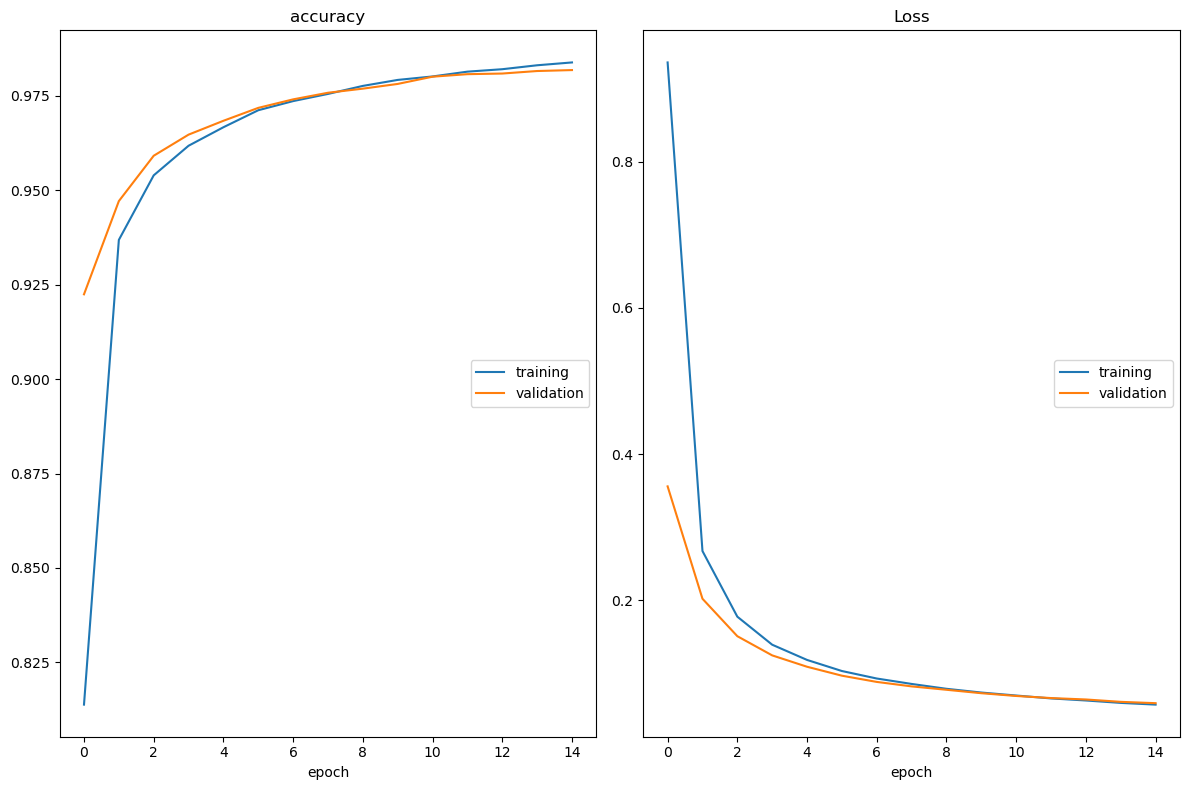

accuracy
	training         	 (min:    0.814, max:    0.984, cur:    0.984)
	validation       	 (min:    0.922, max:    0.982, cur:    0.982)
Loss
	training         	 (min:    0.058, max:    0.936, cur:    0.058)
	validation       	 (min:    0.059, max:    0.356, cur:    0.059)
Tempo gasto: 57.005199378999805 segundos


In [23]:
# treino do modelo CNNModel_3
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [24]:
######### CNNModel_4 ################
model = CNNModel_4()
model.to(device)

CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

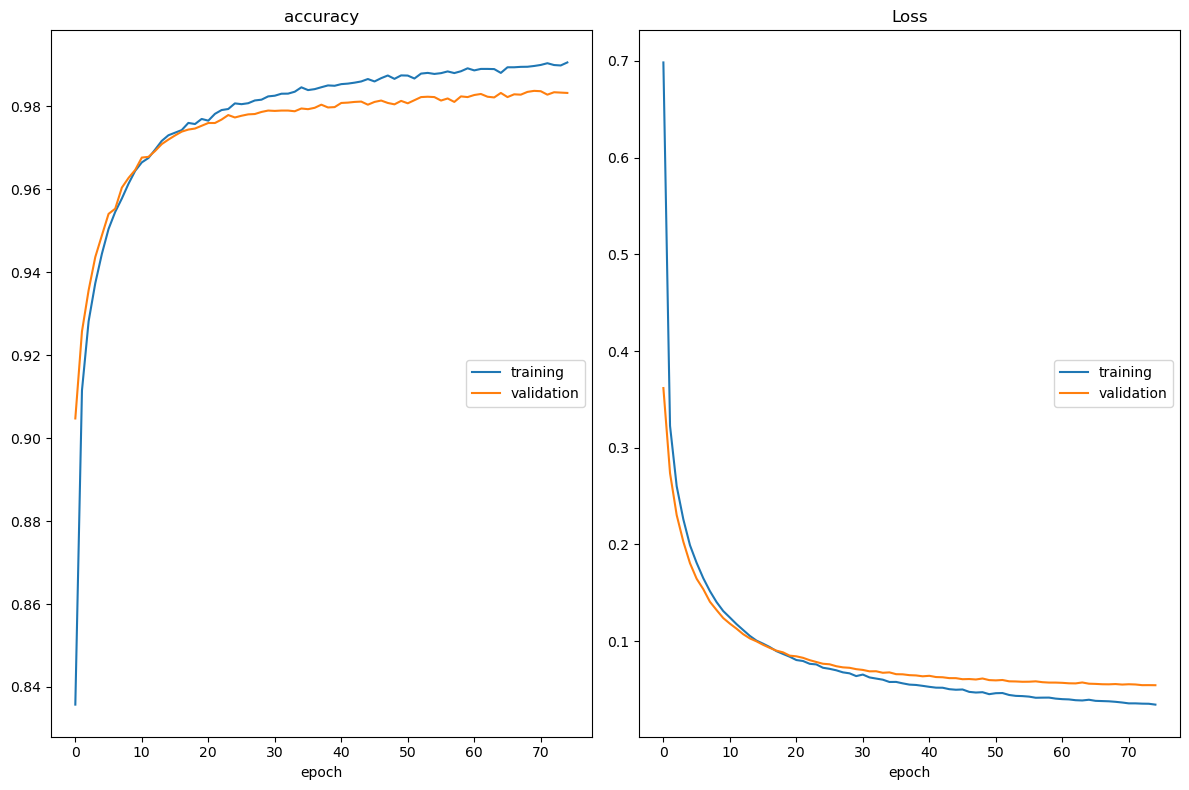

accuracy
	training         	 (min:    0.836, max:    0.991, cur:    0.991)
	validation       	 (min:    0.905, max:    0.984, cur:    0.983)
Loss
	training         	 (min:    0.034, max:    0.698, cur:    0.034)
	validation       	 (min:    0.054, max:    0.362, cur:    0.054)
Tempo gasto: 217.885731997 segundos


In [25]:
#treino do modelo CNNModel_4
EPOCHS = 75
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o Modelo.

real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] previsão:[0]
real:[4] previsão:[4]
real:[1] previsão:[1]
real:[4] previsão:[4]
real:[9] previsão:[4]
real:[5] previsão:[2]
real:[9] previsão:[7]
real:[0] previsão:[0]
real:[6] previsão:[6]
real:[9] previsão:[4]
real:[0] previsão:[0]
real:[1] previsão:[1]
real:[5] previsão:[5]
real:[9] previsão:[4]
real:[7] previsão:[7]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[9] previsão:[7]
Accuracy: 0.749

acertou:7494 falhou:2505
Accuracy: 0.749

acertou:7494 falhou:2505
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       980
           1       0.91      0.97      0.94      1135
           2       0.85      0.91      0.88      1032
           3       0.69      0.92      0.79      1010
           4       0.60      0.95      0.74       982
           5       0.62      0.85      0.72       892
           6       0.87      0.95      0.91       958
           7       0.64      0.92      0.76

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

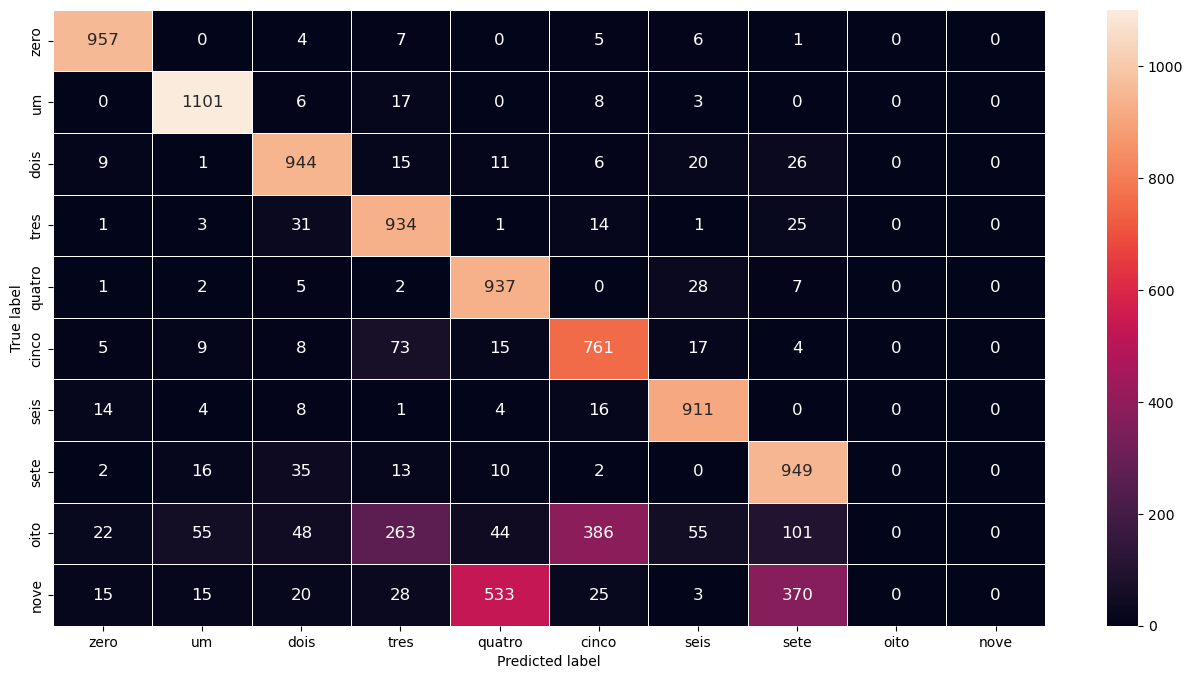

In [ ]:
# Avaliar o modelo
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        # avaliar o modelo com os casos de teste
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        # converter para a class dos labels
        yprev = np.argmax(yprev, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1
    # calcular a accuracy
    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 
    
# avaliar o modelo
model= torch.load('CNNModel_1.pth',weights_only=False)
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

real:[2] previsão:[2]
real:[1] previsão:[1]
real:[0] previsão:[0]
real:[4] previsão:[4]
real:[1] previsão:[1]
real:[4] previsão:[4]
real:[9] previsão:[9]
real:[5] previsão:[5]
real:[9] previsão:[9]
real:[0] previsão:[0]
real:[6] previsão:[6]
real:[9] previsão:[9]
real:[0] previsão:[0]
real:[1] previsão:[1]
real:[5] previsão:[5]
real:[9] previsão:[9]
real:[7] previsão:[7]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[9] previsão:[9]
Accuracy: 0.954

acertou:9536 falhou:463
Accuracy: 0.954

acertou:9536 falhou:463
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.93      0.94      1032
           3       0.93      0.97      0.95      1010
           4       0.97      0.96      0.96       982
           5       0.97      0.93      0.95       892
           6       0.96      0.96      0.96       958
           7       0.96      0.94      0.95  

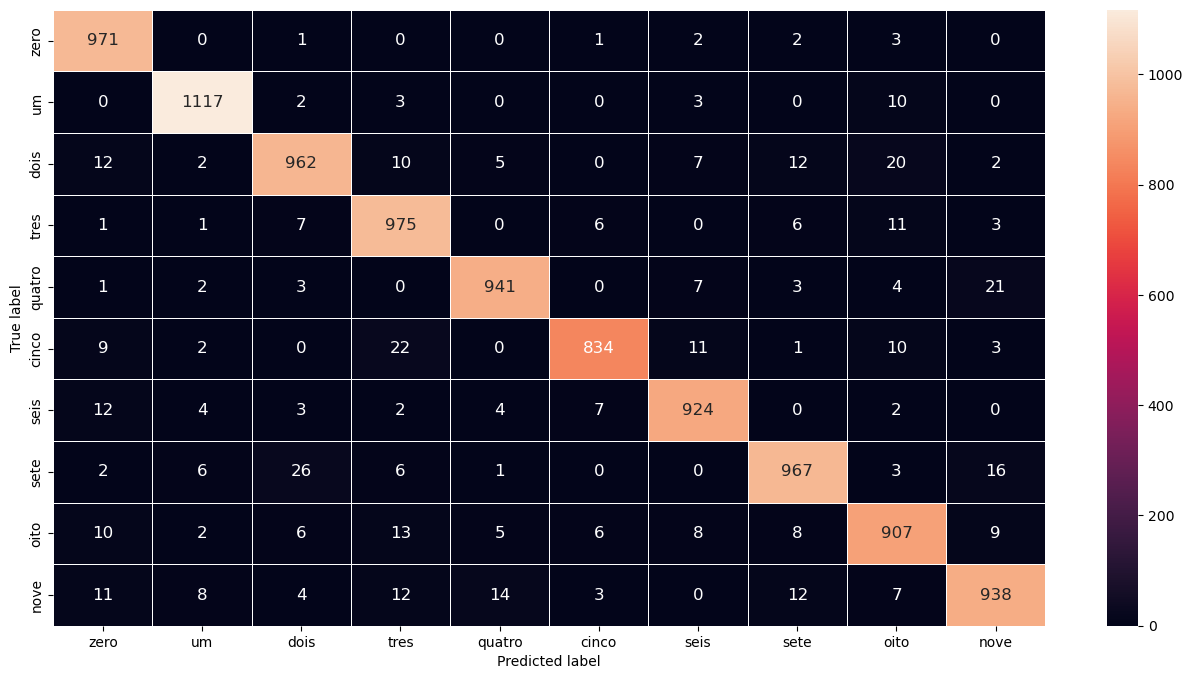

In [27]:
# avaliar o modelo
model= torch.load('CNNModel_2.pth',weights_only=False)
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=[output_label(n,'ext2') for n in list(cr.keys())[0:10] ] 
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

## 5. Usar o Modelo.

torch.Size([1, 1, 28, 28])
torch.float32


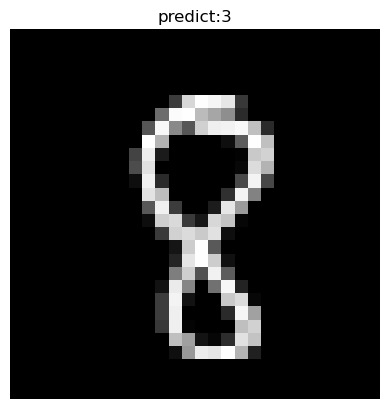

torch.Size([1, 1, 28, 28])
torch.float32


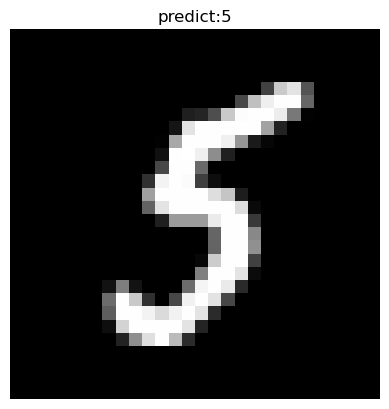

pred: 5
5
CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)


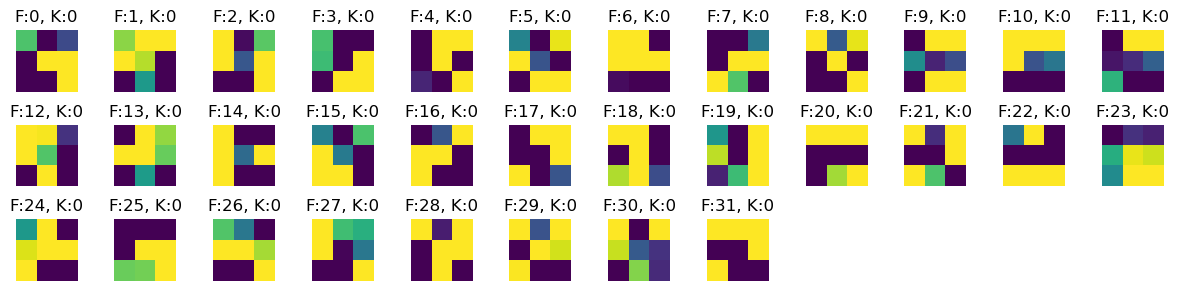

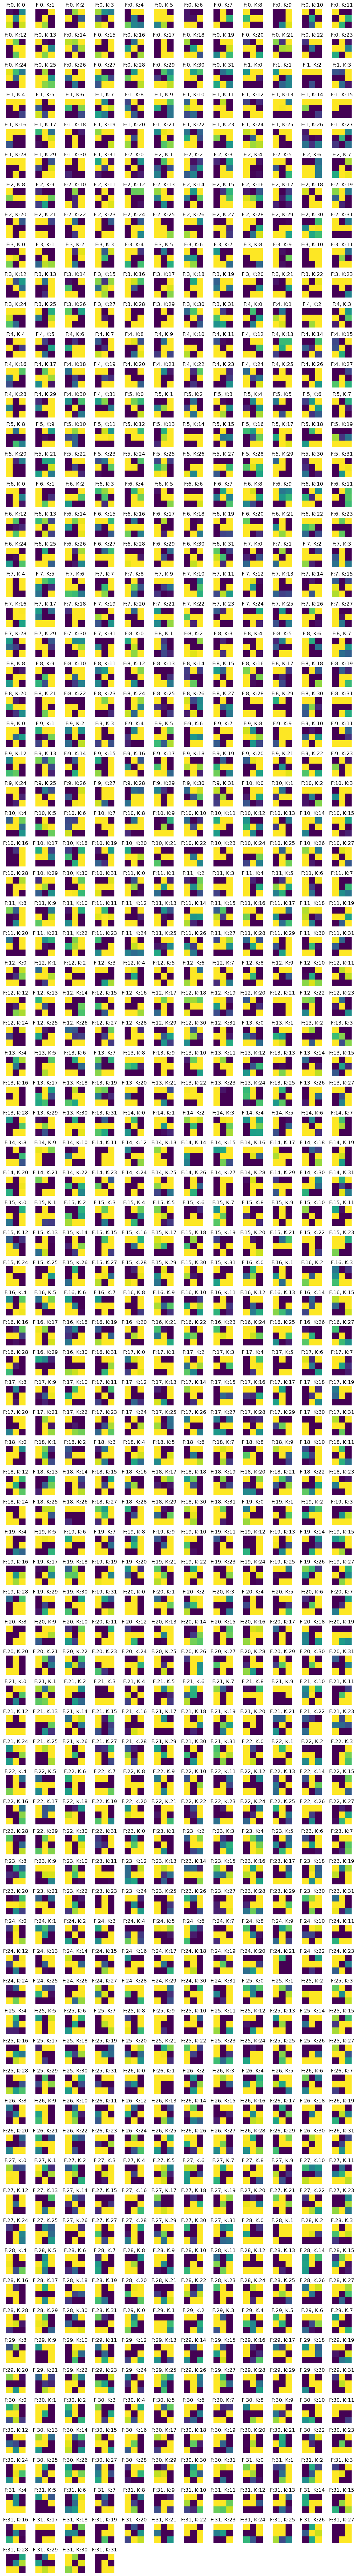

torch.Size([32, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.float32


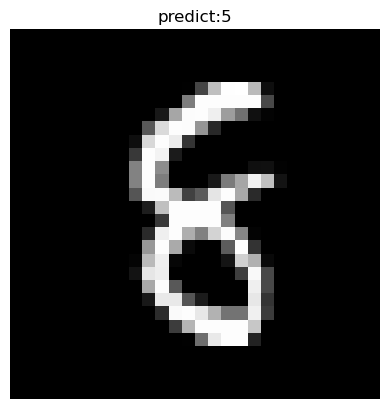

pred: 5
5
torch.Size([32, 1, 28, 28])
[Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False), Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)]
4
Obtiveram-se 4 tensores com o shape:
    Layer 0 - torch.Size([32, 32, 26, 26])
    Layer 1 - torch.Size([32, 32, 13, 13])
    Layer 2 - torch.Size([32, 32, 11, 11])
    Layer 3 - torch.Size([32, 32, 5, 5])
Layer 0 - Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))


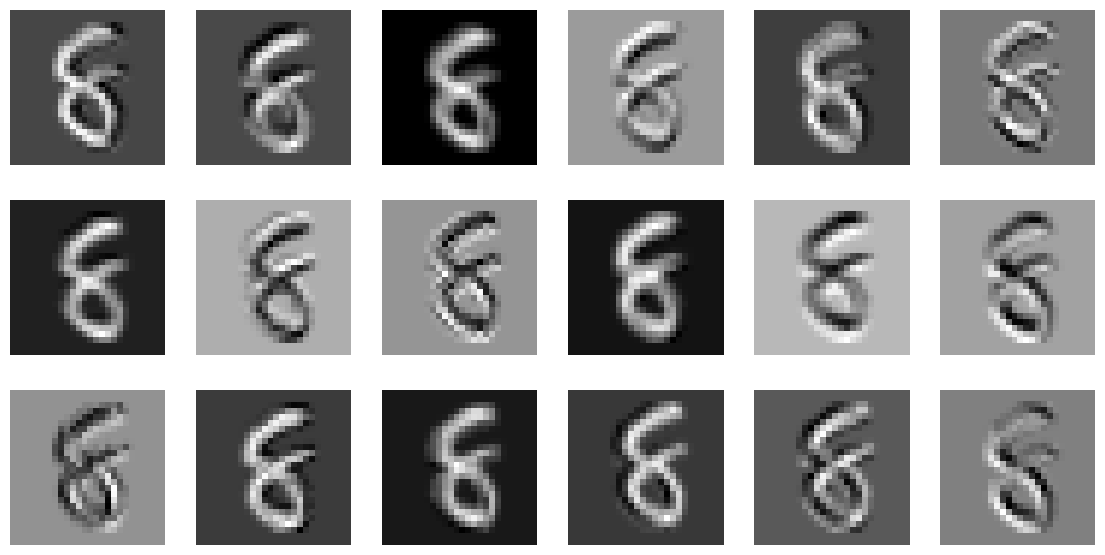

Layer 1 - MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)


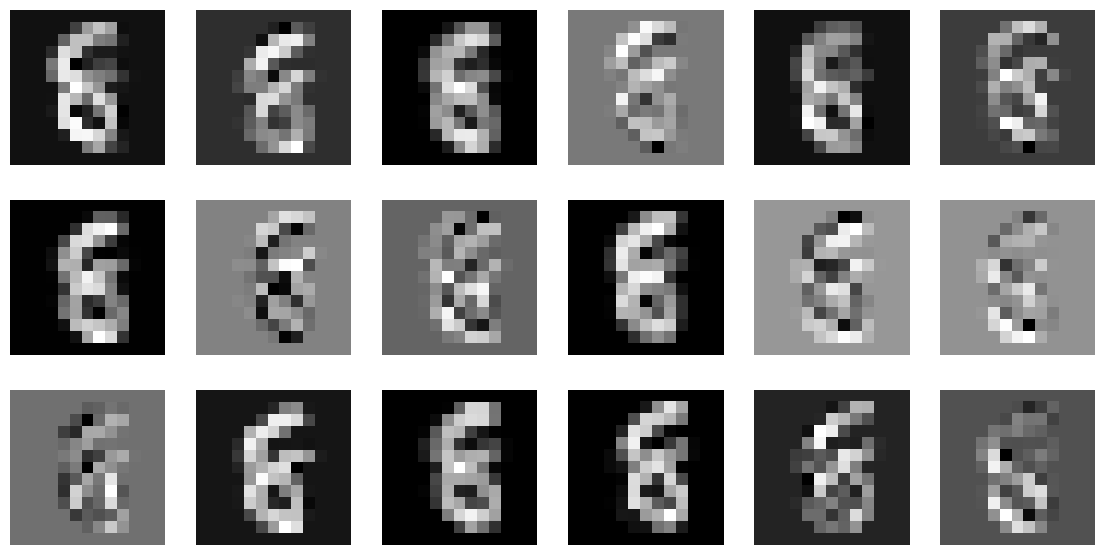

Layer 2 - Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))


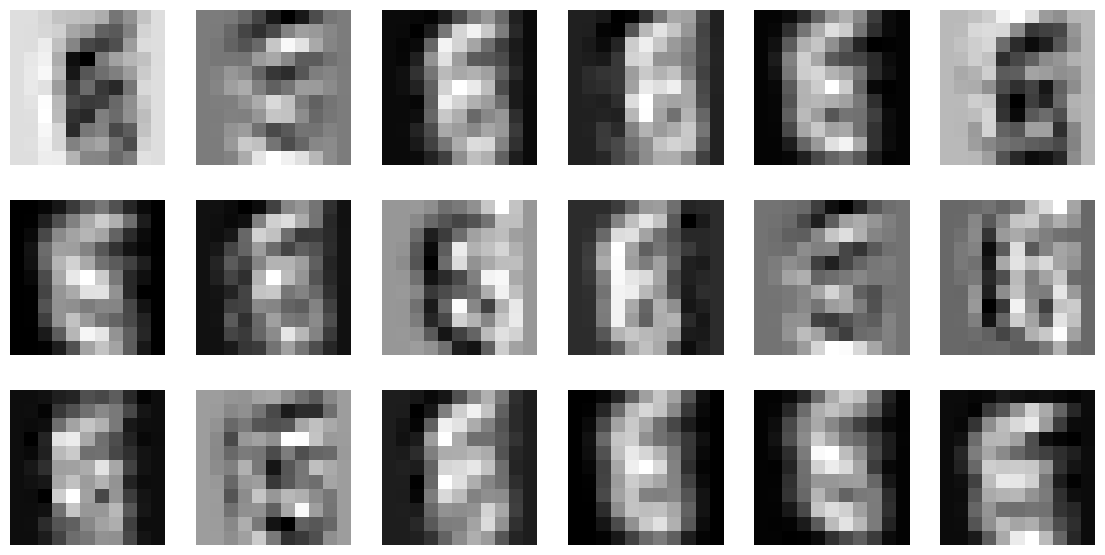

Layer 3 - MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)


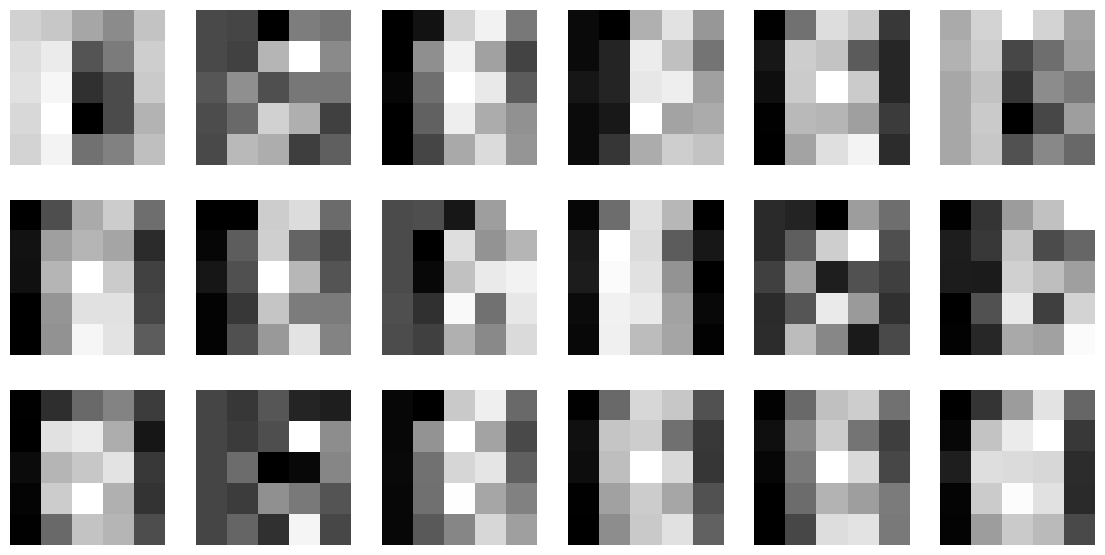

In [30]:
# fazer uma previsão utilizando um caso

def img_show(img, legenda): # img shape (784,1)
    img=img.cpu()
    plt.axis('off')
    plt.title(legenda)
    plt.grid()
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()

def make_prediction(model, img): # img shape (784,1)
    img = img.reshape(1, 1, 28, 28) # shape (1,1,28,28)
    print(img.shape)
    print(img.dtype) # if t is your tensor, else you use t.type() for the other two.
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    legenda=f"predict:{prediction}"
    img_show(img,legenda)
    return prediction

model= torch.load('CNNModel_1.pth',weights_only=False)
model.eval()
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    pred = make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
    print("pred:",pred)
    return imagens, pred

model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(model)
def plot_filters_single_channel_big(t):
    # setting the rows and columns
    print(t.shape)
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    npimg = npimg.T
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)

def plot_filters_single_channel(t):
    nplots = t.shape[0]*t.shape[1]  # number of filters(32) * kernels depth (1) 
    ncols = 12
    nrows = 1 + nplots//ncols
    npimg = np.array(t.numpy(), np.float32) # convert tensor to numpy image
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    for i in range(t.shape[0]): # looping through all the kernels in each channel
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(f"F:{i}, K:{j}")
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    num_kernels = t.shape[0]     # get the number of kernals
    num_cols = 12 # define number of columns for subplots
    num_rows = num_kernels # rows = num of kernels
    fig = plt.figure(figsize=(num_cols,num_rows)) # set the figure size
    for i in range(t.shape[0]): # looping through all the kernels
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        npimg = np.array(t[i].numpy(), np.float32) # for each kernel, we convert the tensor to numpy
        npimg = (npimg - np.mean(npimg)) / np.std(npimg) # standardize the numpy image
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
    plt.savefig('kernels.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(layer, single_channel = True, collated = False):
    if isinstance(layer, nn.Conv2d):
        weight_tensor = layer.weight.data #getting the weight tensor data (filter or set of kernels)
        if single_channel:
            if collated:
                plot_filters_single_channel_big(weight_tensor.cpu())
            else:
                plot_filters_single_channel(weight_tensor.cpu() )
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor.cpu())
            else:
                print("Can only plot weights with three channels with single channel = False")
    else:
        print("Can only visualize layers which are convolutional")
        
# visualize weights for model - first conv layer 0 of layer1 sequential
plot_weights(model.layer1[0], single_channel = True)
plot_weights(model.layer2[0], single_channel = True)
# visualizar os featuremaps

def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    print(imagens.shape)
    pred = make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
    print("pred:",pred)
    return imagens, pred

#model= torch.load('CNNModel_1.pth')
#model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(images.shape)
# MaxPool2d

def get_conv_layers(model):
    conv_layers=list()
    model_children=list(model.children())
    for child in model_children:
        if type(child)==Conv2d:
            conv_layers.append(child)
        elif type(child)==Sequential:   # para o caso de termos agrupado num layer sequential
            for layer in child.children():
                if type(layer)==Conv2d:
                    conv_layers.append(layer)
    return conv_layers

def get_conv_pool_layers(model): # inclui o MaxPool2d
    conv_layers=[]
    model_children=list(model.children())
    for child in model_children:
        if type(child)==Conv2d or type(child)==MaxPool2d:
            conv_layers.append(child)
        elif type(child)==Sequential:   # para o caso de termos agrupado num layer sequential
            for layer in child.children():
                if type(layer)==Conv2d or (type(layer)==MaxPool2d):
                    conv_layers.append(layer)
    return conv_layers

conv_layers = get_conv_pool_layers(model)
print(conv_layers)
print(len(conv_layers)) # num_layers_conv
# percorrer todos os layers do modelo até chegar ao último layer Conv2d
def percorrer_conv_layers(images, conv_layers):
    images = images.to(device)
    results = [conv_layers[0](images)]
    for i in range(1, len(conv_layers)):
        results.append(conv_layers[i](results[-1]))
    outputs = results
    return outputs

outputs = percorrer_conv_layers(images, conv_layers)
print(f"Obtiveram-se {len(outputs)} tensores com o shape:")
for i in range(len(outputs)):
    print(f"    Layer {i} - {outputs[i].shape}")
# visualize featureMaps

def visualize_featureMaps_partial(outputs,conv_layers, num_imagem):
    for num_layer in range(len(outputs)):
        plt.figure(figsize=(14, 7))
        layer_viz = outputs[num_layer][num_imagem, :, :, :]
        layer_viz = layer_viz.data
        print(f"Layer {num_layer} - {conv_layers[num_layer]}")
        for i, filter in enumerate(layer_viz):
            if i == 18: 
                break
            plt.subplot(3, 6, i + 1)
            plt.imshow(filter.cpu(), cmap='gray')
            plt.axis("off")
        plt.show()
        plt.close()

visualize_featureMaps_partial(outputs,conv_layers,3)

torch.Size([1, 1, 28, 28])
torch.float32


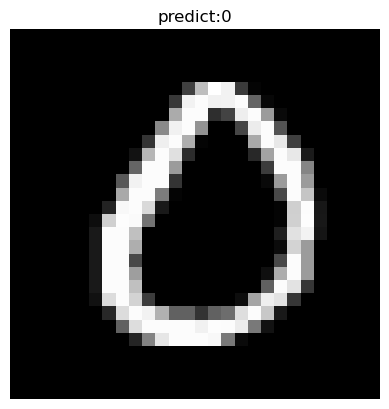

torch.Size([1, 1, 28, 28])
torch.float32


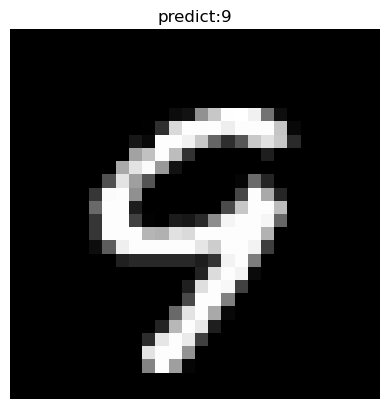

pred: 9
9
CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)


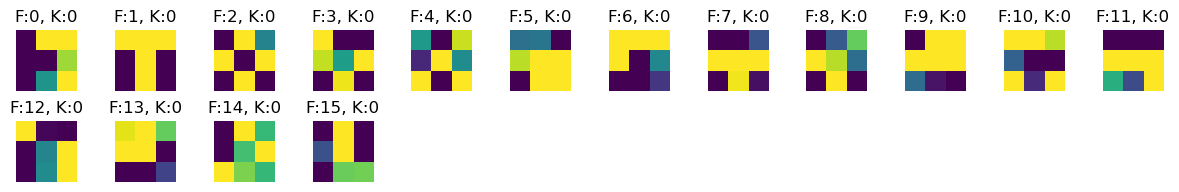

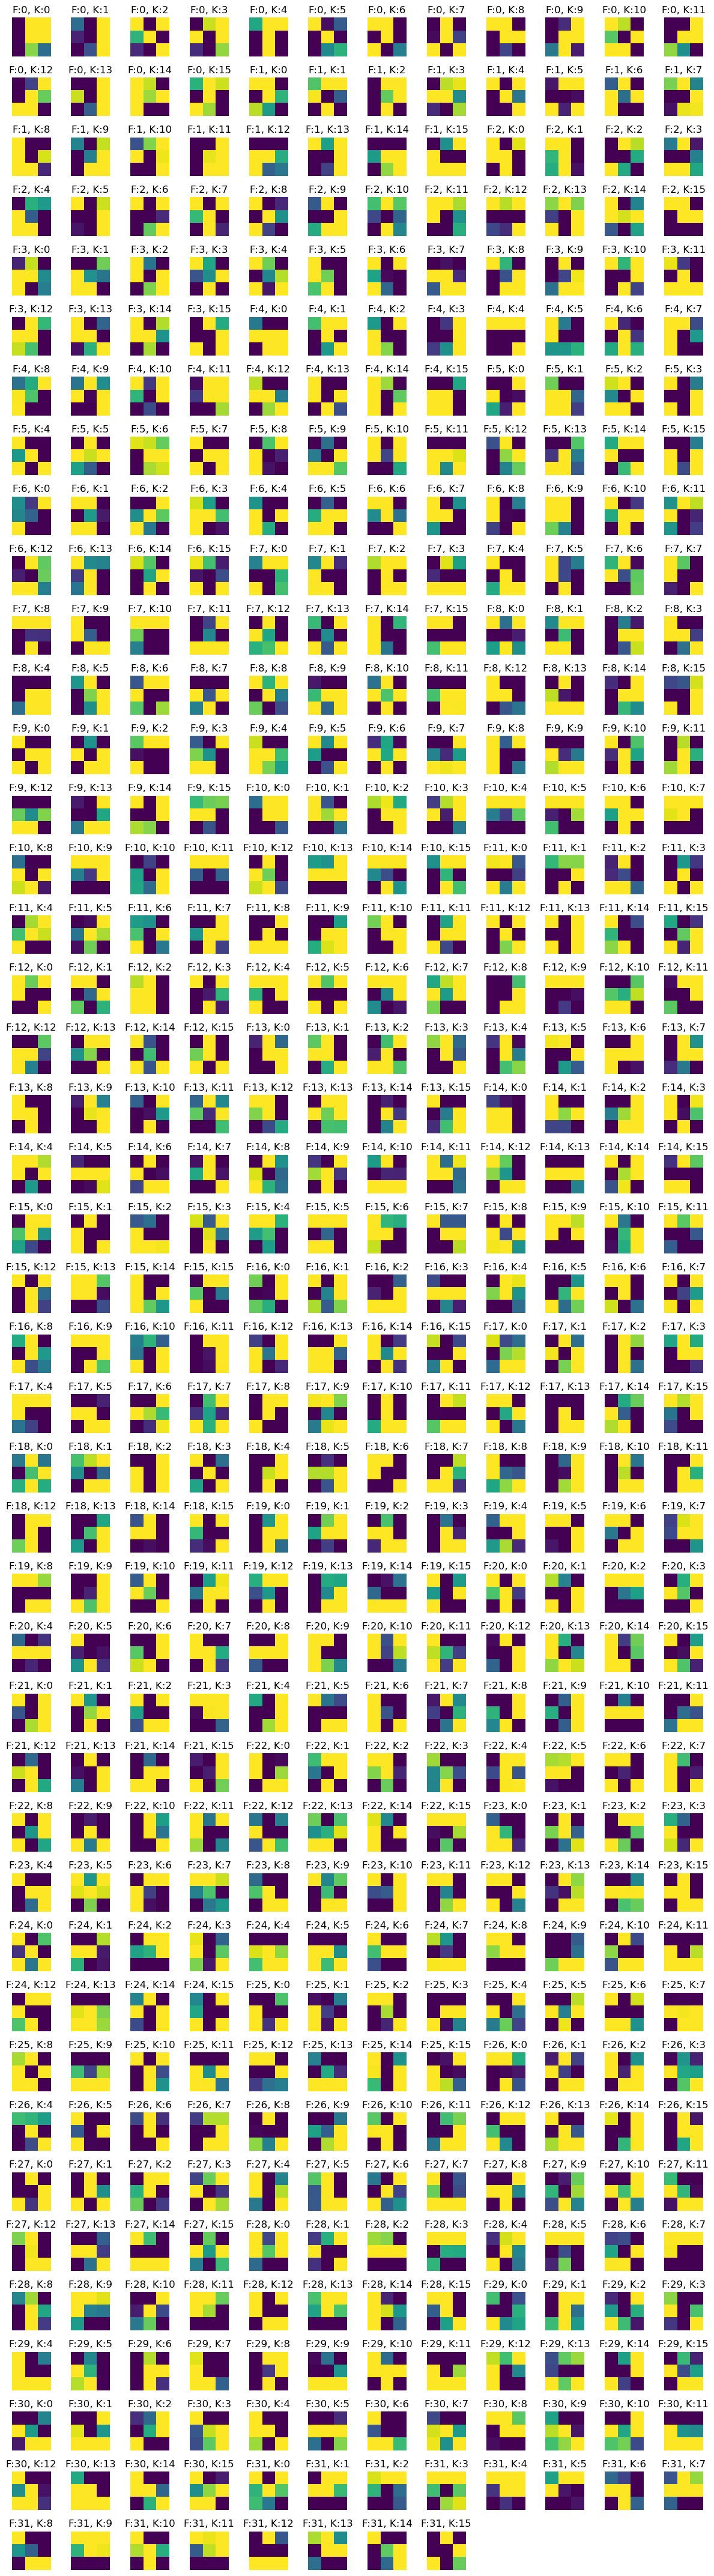

torch.Size([1, 1, 28, 28])
torch.float32


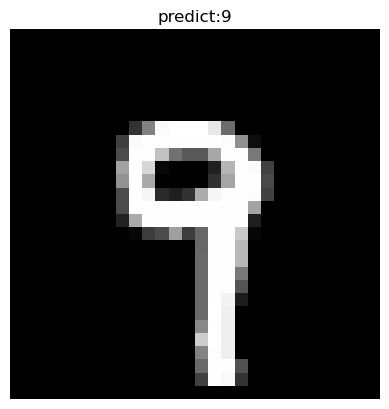

pred: 9
9
torch.Size([32, 1, 28, 28])
[Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
4
Obtiveram-se 4 tensores com o shape:
    Layer 0 - torch.Size([32, 16, 26, 26])
    Layer 1 - torch.Size([32, 16, 13, 13])
    Layer 2 - torch.Size([32, 32, 11, 11])
    Layer 3 - torch.Size([32, 32, 5, 5])
Layer 0 - Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))


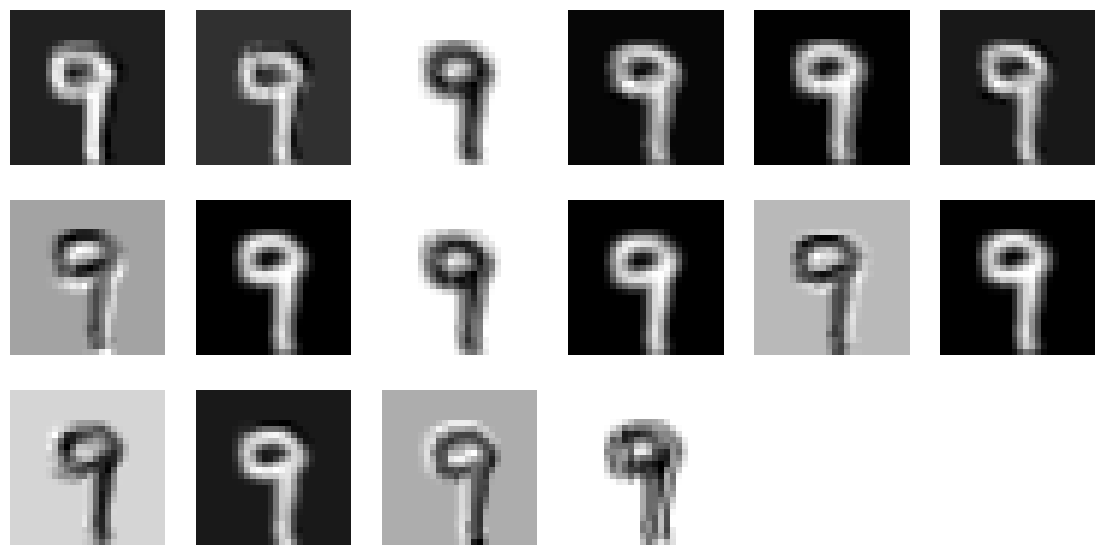

Layer 1 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


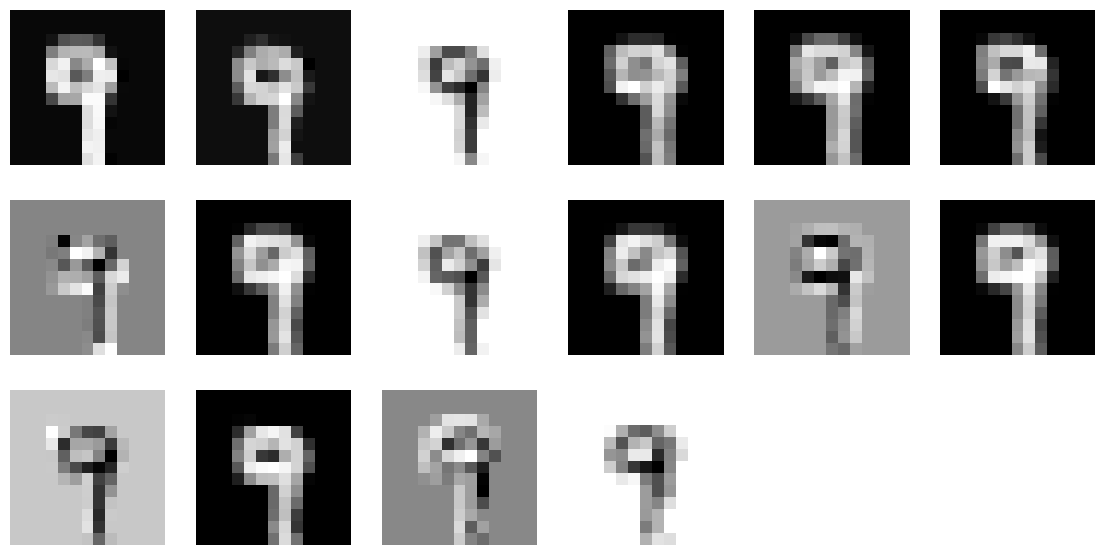

Layer 2 - Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))


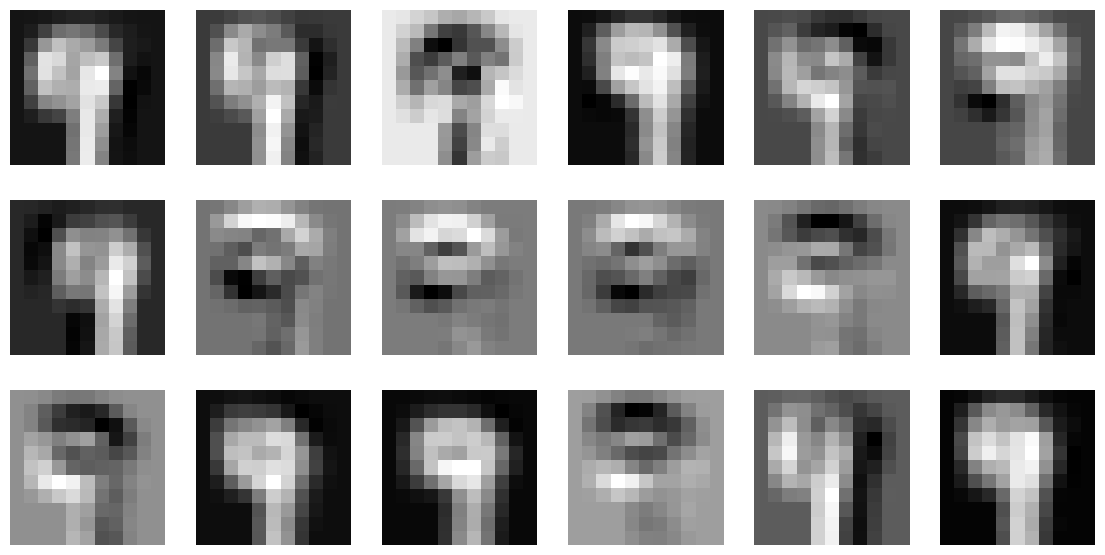

Layer 3 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


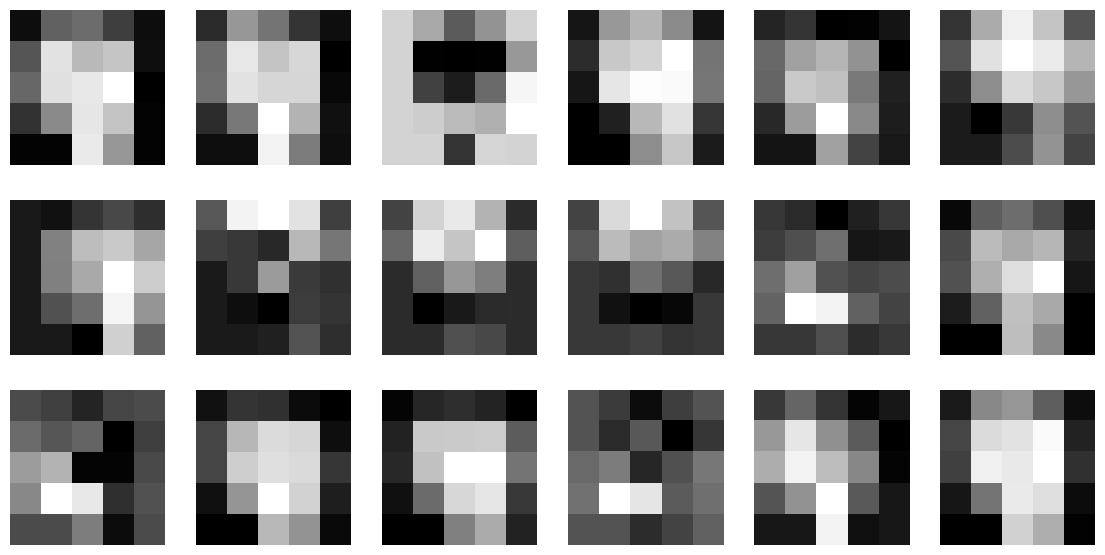

In [31]:
# fazer uma previsão utilizando um caso

model= torch.load('CNNModel_2.pth',weights_only=False)
model.eval()
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    pred = make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
    print("pred:",pred)
    return imagens, pred

model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(model)
        
# visualize weights for model - first conv layer 0 of layer1 sequential
plot_weights(model.layer1[0], single_channel = True)
plot_weights(model.layer2[0], single_channel = True)
# visualizar os featuremaps
#model= torch.load('CNNModel_1.pth')
#model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(images.shape)
# MaxPool2d
conv_layers = get_conv_pool_layers(model)
print(conv_layers)
print(len(conv_layers)) # num_layers_conv
# percorrer todos os layers do modelo até chegar ao último layer Conv2d
outputs = percorrer_conv_layers(images, conv_layers)
print(f"Obtiveram-se {len(outputs)} tensores com o shape:")
for i in range(len(outputs)):
    print(f"    Layer {i} - {outputs[i].shape}")
# visualize featureMaps
visualize_featureMaps_partial(outputs,conv_layers,3)

torch.Size([1, 1, 28, 28])
torch.float32


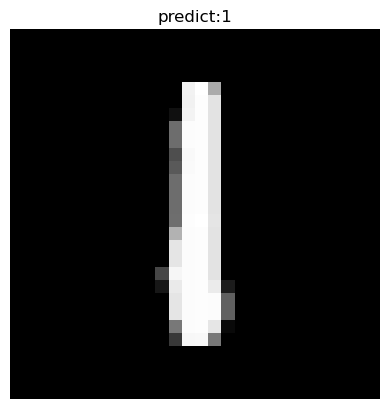

torch.Size([1, 1, 28, 28])
torch.float32


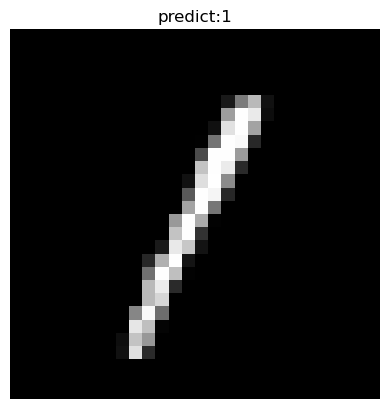

pred: 1
1
CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


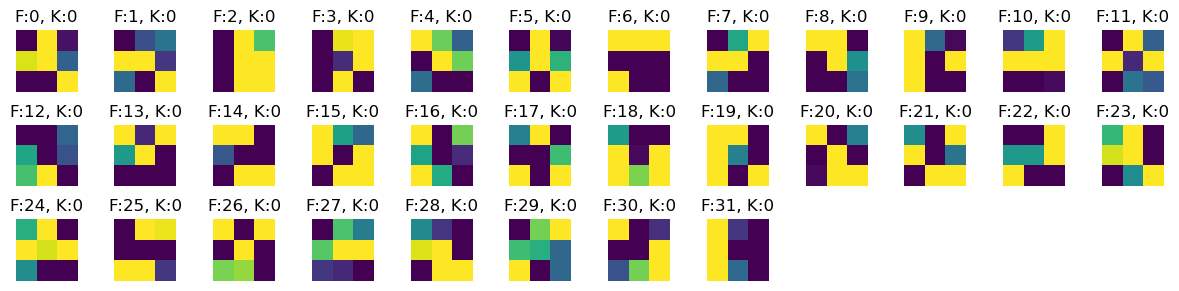

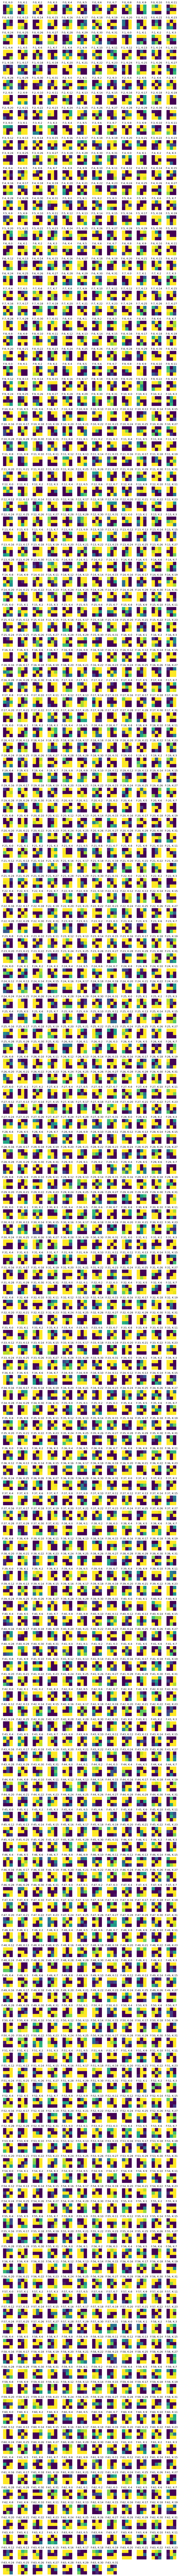

torch.Size([1, 1, 28, 28])
torch.float32


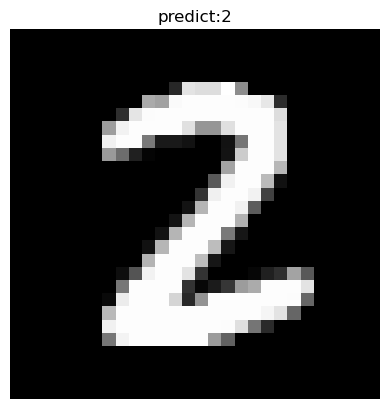

pred: 2
2
torch.Size([32, 1, 28, 28])
[Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
4
Obtiveram-se 4 tensores com o shape:
    Layer 0 - torch.Size([32, 32, 28, 28])
    Layer 1 - torch.Size([32, 32, 14, 14])
    Layer 2 - torch.Size([32, 64, 12, 12])
    Layer 3 - torch.Size([32, 64, 6, 6])
Layer 0 - Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


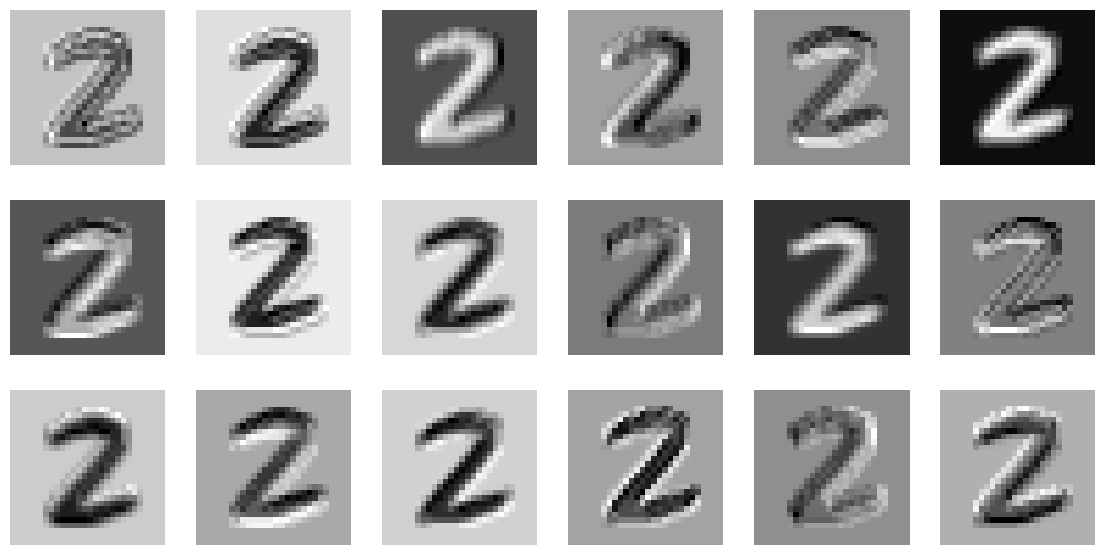

Layer 1 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


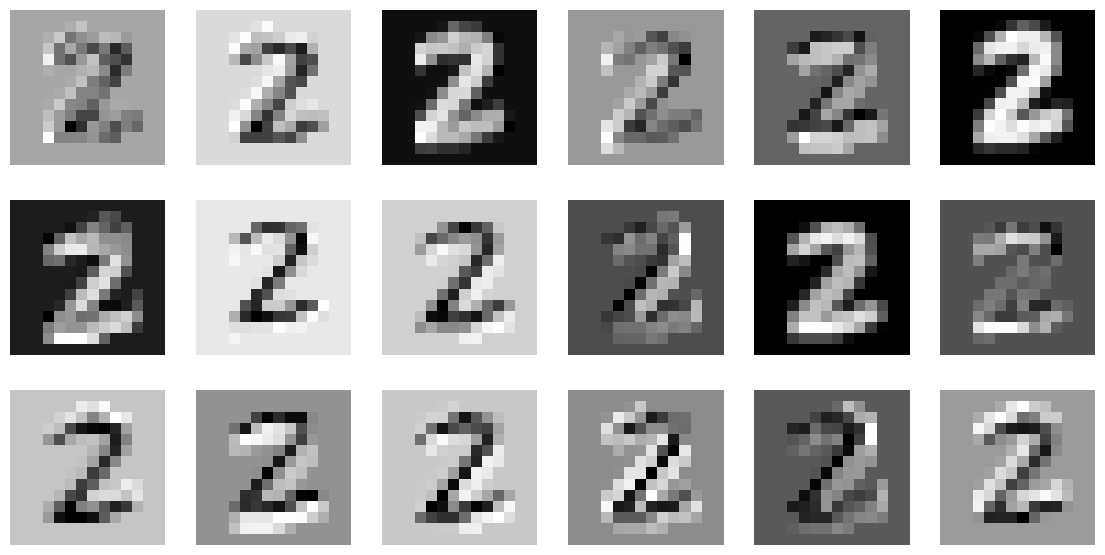

Layer 2 - Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))


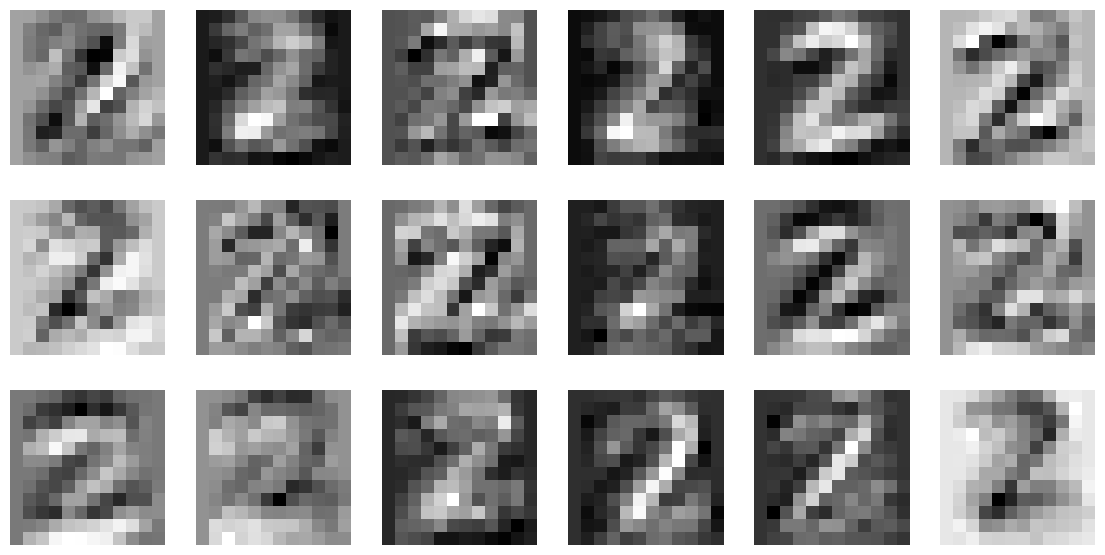

Layer 3 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


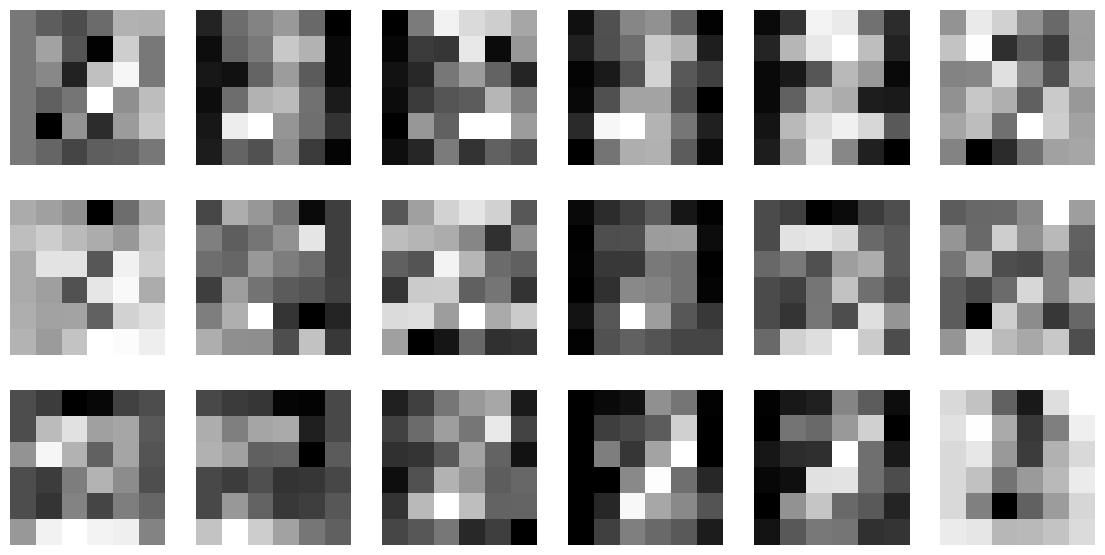

In [32]:
# fazer uma previsão utilizando um caso

model= torch.load('CNNModel_3.pth',weights_only=False)
model.eval()
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    pred = make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
    print("pred:",pred)
    return imagens, pred

model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(model)
        
# visualize weights for model - first conv layer 0 of layer1 sequential
plot_weights(model.layer1[0], single_channel = True)
plot_weights(model.layer2[0], single_channel = True)
# visualizar os featuremaps
#model= torch.load('CNNModel_1.pth')
#model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(images.shape)
# MaxPool2d
conv_layers = get_conv_pool_layers(model)
print(conv_layers)
print(len(conv_layers)) # num_layers_conv
# percorrer todos os layers do modelo até chegar ao último layer Conv2d
outputs = percorrer_conv_layers(images, conv_layers)
print(f"Obtiveram-se {len(outputs)} tensores com o shape:")
for i in range(len(outputs)):
    print(f"    Layer {i} - {outputs[i].shape}")
# visualize featureMaps
visualize_featureMaps_partial(outputs,conv_layers,3)

torch.Size([1, 1, 28, 28])
torch.float32


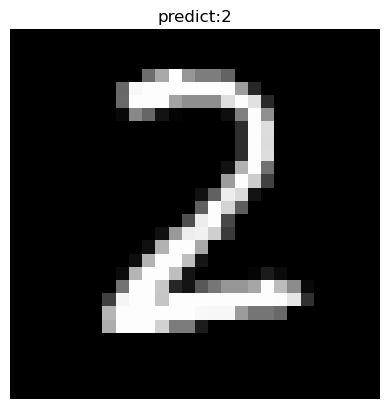

torch.Size([1, 1, 28, 28])
torch.float32


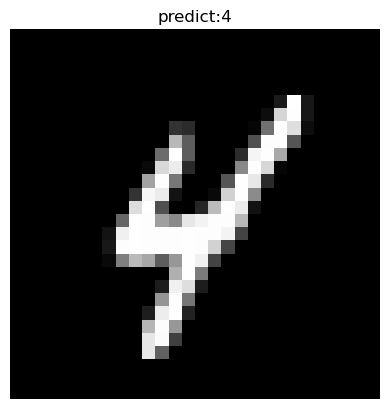

pred: 4
4
CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


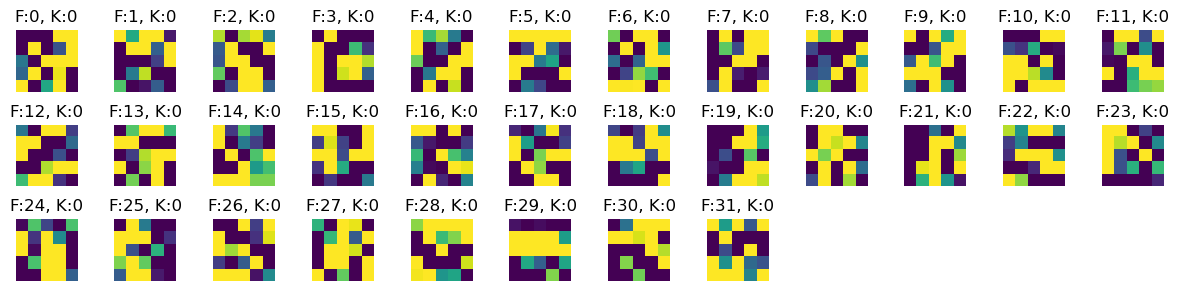

torch.Size([1, 1, 28, 28])
torch.float32


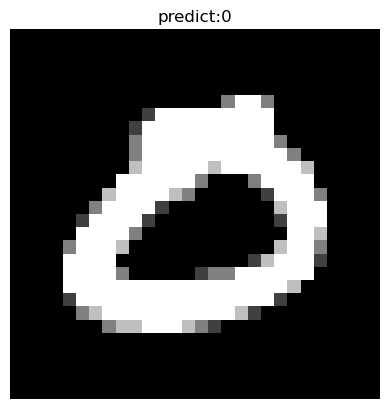

pred: 0
0
torch.Size([32, 1, 28, 28])
[Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
2
Obtiveram-se 2 tensores com o shape:
    Layer 0 - torch.Size([32, 32, 24, 24])
    Layer 1 - torch.Size([32, 32, 12, 12])
Layer 0 - Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))


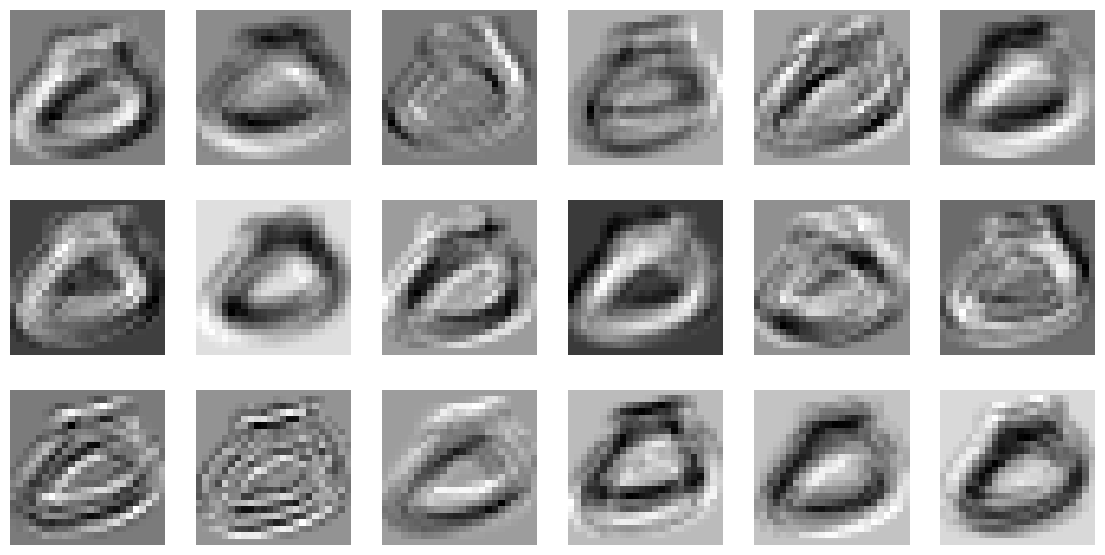

Layer 1 - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


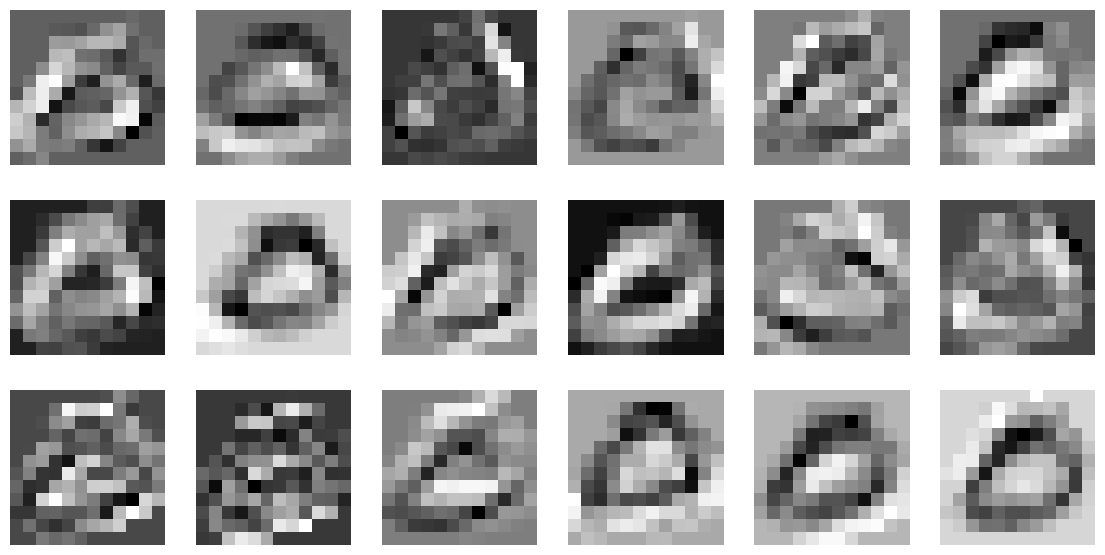

In [33]:
# fazer uma previsão utilizando um caso

model= torch.load('CNNModel_4.pth',weights_only=False)
model.eval()
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
def show_batch_images(model,dataloader,num_image):
    imagens, label = next(iter(test_dl))
    pred = make_prediction(model,imagens[3]) # receives an image tensor with shape (784,1)
    print("pred:",pred)
    return imagens, pred

model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(model)
        
# visualize weights for model - first conv layer 0 of layer1 sequential
plot_weights(model.layer1[0], single_channel = True)
# visualizar os featuremaps
#model= torch.load('CNNModel_1.pth')
#model.eval()
images, pred = show_batch_images(model,test_dl,1)
print(pred)
print(images.shape)
# MaxPool2d
conv_layers = get_conv_pool_layers(model)
print(conv_layers)
print(len(conv_layers)) # num_layers_conv
# percorrer todos os layers do modelo até chegar ao último layer Conv2d
outputs = percorrer_conv_layers(images, conv_layers)
print(f"Obtiveram-se {len(outputs)} tensores com o shape:")
for i in range(len(outputs)):
    print(f"    Layer {i} - {outputs[i].shape}")
# visualize featureMaps
visualize_featureMaps_partial(outputs,conv_layers,3)